## BloomTech Data Science

---


In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Define ML Problems
- Data Leakage
- ROC/AUC Curve



In [16]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, \
    RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

In [17]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator
plot_roc_curve = RocCurveDisplay.from_estimator

In [18]:
pd.set_option('display.max_columns', 500)

# Define ML problems

# I. Wrangle Data

In [19]:
DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'

pd.read_csv(DATA_PATH + 'burritos/burritos.csv')

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Valentine's Mexican Food,Al Pastor,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,3.50,NaN,Anon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,Valentine's Mexican Food,Chile Relleno,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,4.00,NaN,Bonnie,non-symmetric wrapping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,Valentine's Mexican Food,California,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,3.50,NaN,Scott,way too small and not enough meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,Valentine's Mexican Food,Shrimp,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,4.00,NaN,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def wrangle(filepath):

    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

    # drop rows with no overall rating
    df.dropna(subset=['overall'], inplace=True)

    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int)

    # Drop overall column to prevent data leakage
    df.drop(columns='overall', inplace=True)

    # Clean binary encoded columns
    categorical_cols = df.select_dtypes('object').columns
    # use categorical columns which are basically binary encoded
    binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)

    # Drop high-cardinality categorical variables
    threshold = 20

    high_card_cols = [col for col in categorical_cols
                      if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)

    # Dropping columns with high number of NaN values
    df.dropna(axis=1, thresh=300, inplace=True)

    return df

In [21]:
df = wrangle(DATA_PATH + 'burritos/burritos.csv')
df.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cost           414 non-null    float64
 1   Hunger         418 non-null    float64
 2   Tortilla       421 non-null    float64
 3   Temp           401 non-null    float64
 4   Meat           407 non-null    float64
 5   Fillings       418 non-null    float64
 6   Meat:filling   412 non-null    float64
 7   Uniformity     419 non-null    float64
 8   Salsa          396 non-null    float64
 9   Synergy        419 non-null    float64
 10  Wrap           418 non-null    float64
 11  Unreliable     421 non-null    int64  
 12  NonSD          421 non-null    int64  
 13  Beef           421 non-null    int64  
 14  Pico           421 non-null    int64  
 15  Guac           421 non-null    int64  
 16  Cheese         421 non-null    int64  
 17  Fries          421 non-null    int6

# II. Split Data

In [23]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

<Axes: >

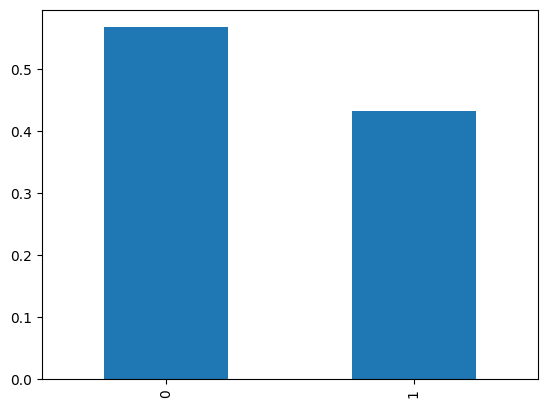

In [24]:
y.value_counts(normalize=True).plot(kind='bar')

<Axes: >

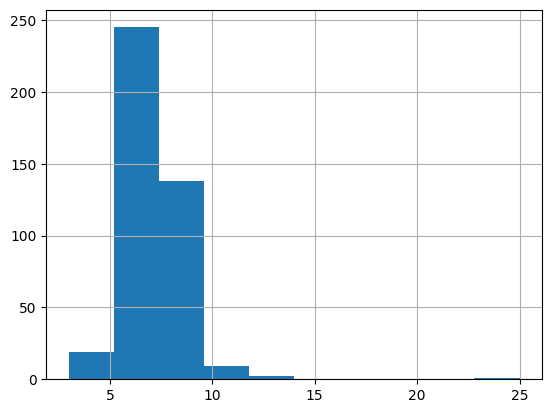

In [25]:
X['Cost'].hist()

In [26]:
y.resample('y').sum()

Date
2011-12-31      0
2012-12-31      0
2013-12-31      0
2014-12-31      0
2015-12-31      1
2016-12-31    121
2017-12-31     38
2018-12-31     13
2019-12-31      8
2020-12-31      0
2021-12-31      0
2022-12-31      0
2023-12-31      0
2024-12-31      0
2025-12-31      0
2026-12-31      1
Freq: A-DEC, Name: great, dtype: int64

In [30]:
# Training
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation
validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing
test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

# III. Establish Baseline

In [31]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build Model

In [32]:
# Model 1: Logistic Regression

model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [33]:
# Model 2: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**

accuracy = (tp + tn) / (tp + fp + tn + fn)

In [34]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


In [35]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.9058823529411765


**Precision, Recall, F1**

precision = tp / (tp + fp)


recall = tp / (tp + fn)

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



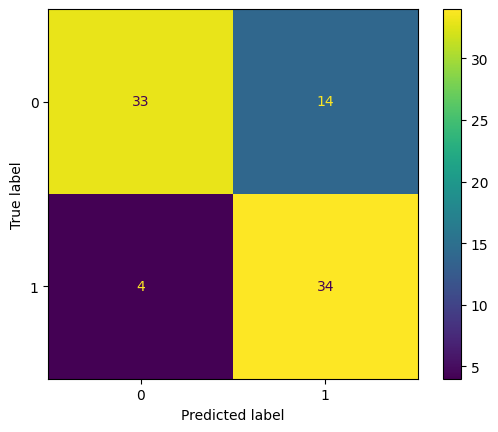

In [36]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        47
           1       0.89      0.89      0.89        38

    accuracy                           0.91        85
   macro avg       0.90      0.90      0.90        85
weighted avg       0.91      0.91      0.91        85



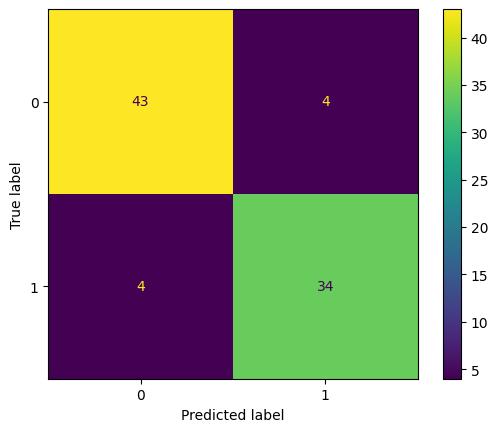

In [38]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)

**ROC curve**


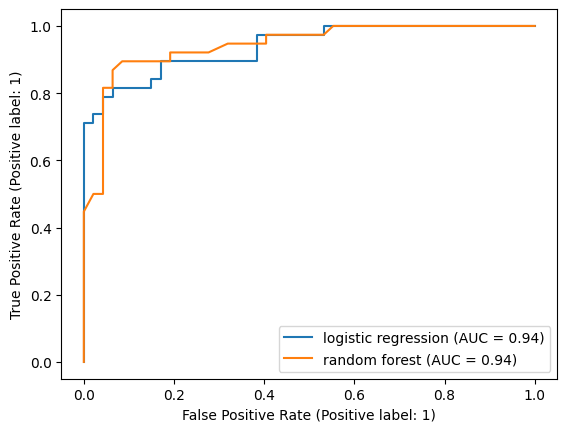

In [44]:
lr = plot_roc_curve(
    model_lr,
    X_val,
    y_val,
    name = 'logistic regression'
)

rf = plot_roc_curve(
    model_rf,
    X_val,
    y_val,
    ax = lr.ax_,
    name = 'random forest'
)

In [45]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.942889137737962

In [46]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.9384098544232923

In [48]:
# Get predicted probabilities from model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds': thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,2.00
1,0.000000,0.052632,1.00
2,0.000000,0.105263,0.99
3,0.000000,0.157895,0.96
4,0.000000,0.236842,0.95
5,0.000000,0.447368,0.81
6,0.021277,0.500000,0.80
7,0.042553,0.500000,0.79
8,0.042553,0.526316,0.78
9,0.042553,0.578947,0.77


## Demonstrating how changing the threshold (from roc-auc curve) changes the metrics

In [52]:
y_pred_prob[y_pred_prob >= 0.61] = 1
y_pred_prob[y_pred_prob < 0.61] = 0

In [53]:
from sklearn.metrics import accuracy_score

print('Validation Accuracy (RF):', accuracy_score(y_val, y_pred_prob))

Validation Accuracy (RF): 0.8823529411764706


              precision    recall  f1-score   support

           0       0.91      0.91      0.91        47
           1       0.89      0.89      0.89        38

    accuracy                           0.91        85
   macro avg       0.90      0.90      0.90        85
weighted avg       0.91      0.91      0.91        85



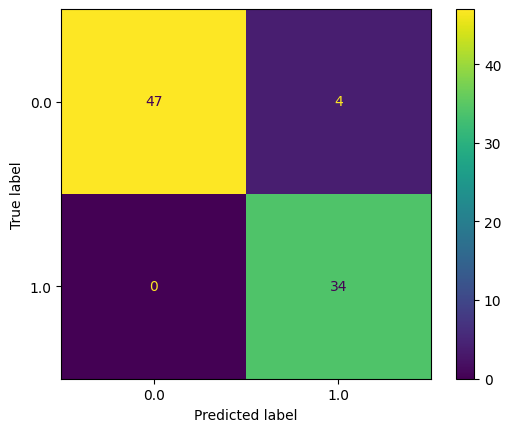

In [54]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_pred_prob);

## Regression Example

What if we were predicting the cost of a burrito?


In [ ]:
# target = 'Cost'
# y = df[target]
# X = df.drop(columns=target)

In [ ]:
# df['Cost'].hist(bins=20) # to check for target skewness

In [ ]:
# Radomized Train Test Split
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# from sklearn.metrics import mean_absolute_error
# baseline_pred = [y_val.mean()] * len(y_val)
# mean_absolute_error(y_val, baseline_pred)

In [ ]:

# model_lr = make_pipeline(SimpleImputer(),
#                       StandardScaler(),
#                       LinearRegression())

# model_lr.fit(X_train, y_train)

In [ ]:

# model_rf = make_pipeline(SimpleImputer(),
#                       RandomForestRegressor())

# model_rf.fit(X_train, y_train)

In [ ]:
# print("Training Accuracy - Linear Regression", mean_absolute_error(y_train, model_lr.predict(X_train)))
# print("Validation Accuracy - Linear Regression", mean_absolute_error(y_val, model_lr.predict(X_val)))

In [ ]:
# print("Training Accuracy - Random Forest", mean_absolute_error(y_train, model_rf.predict(X_train)))
# print("Validation Accuracy - Random Forest", mean_absolute_error(y_val, model_rf.predict(X_val)))

# Log Transformation of skewed Target (for regression)

In [ ]:
# The chosen target for the above example (burrito cost) is not skewed. But if your regression target is skewed, then you should log transform it, using the following steps:

# log transform your target (training set)
# y_train_log = np.log1p(y_train)

# fit your chosen model to this log tranformed target
# model.fit(X_train, y_train_log)

# get your predictions for this log tranformed target
# y_pred_log = model.predict(X_val)

# reverse log tranform your log tranformed target
# y_pred = np.expm1(y_pred_log)

# check your metrics
# print(mean_absolute_error(y_val, y_pred))


# Sampling of imbalance data (using .sample function)

This is just one way to over or under sample. Go over these links and read how to implement SMOTE(Synthetic Minority Oversampling Technique) technique too, where you create synthetic observations of the minority class!

* https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html
* https://www.section.io/engineering-education/imbalanced-data-in-ml/

In [ ]:
# # Sampling of imbalance data (using .sample function)

# # If train_minority contains only those rows in your training dataset that correspond to minority class, you can oversample like this.
# # When you over sample your minority class, you always have to sample with replacement

# num_minority_samples = 10 # number of additional minority class rows to create.
# train_minority_sample = train_minority.sample(num_minority_samples,replace = True)


# # If train_majority contains only those rows in your dataset that correspond to majority class, you can undersample like this.
# # Under sampling doesnt need with replacement
# num_majority_samples = 10 # number of majority class rows to remove.
# train_majority_sample = train_majority.sample(num_majority_samples,replace=False)

# # You can then append the two dataframes to form a final train df.
# train_final = train_minority_sample.append(train_majority_sample, ignore_index=True)
